# Augmentation

Augmentation for MRI has its limitaions. The model needs to recognize a specific pattern or shape that is common for each class and it can be disturbed by the augmentation. I will fit the models using augmented images from ImageDataGenerator and Albumentations.

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import cast, image, numpy_function
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import resnet50
from tensorflow.image import grayscale_to_rgb
from tensorflow import convert_to_tensor
from tensorflow.keras.utils import to_categorical

import albumentations as A
import cv2
from os import listdir
from sklearn.model_selection import train_test_split
import functions
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(18)

In [51]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

In [69]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        zoom_range=0.1,        
        width_shift_range=0.05,
        height_shift_range=0.05, 
        horizontal_flip=True,
        validation_split=0.20) 

Found 5121 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


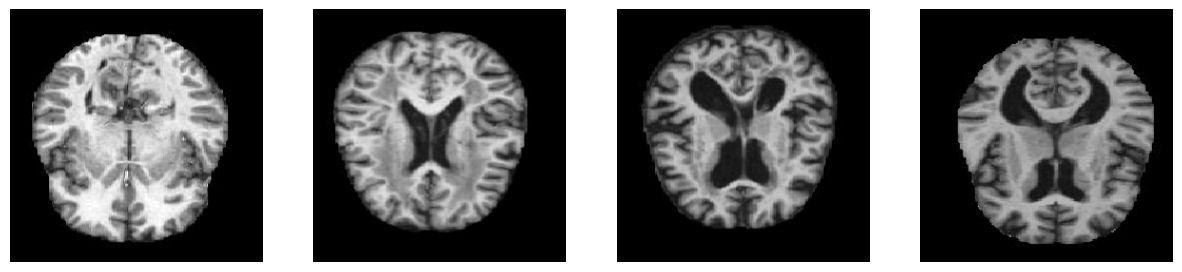

In [60]:
al_train_dg = datagen.flow_from_directory(
                  directory=al_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18 # to make the result reproducible
                  )

al_val_dg = datagen.flow_from_directory(
                  directory=al_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='validation'
                  )


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    # convert to unsigned integers for plotting
    image = next(al_train_dg)[0].astype('uint8')

    # changing size for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

In [7]:
es = EarlyStopping(patience = 5)

model = Sequential()


model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Second Convolution
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(32, activation = 'relu'))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_dg, validation_data = al_val_dg, steps_per_epoch=len(al_train_dg) / 32, epochs=50, callbacks = [es])

Epoch 1/50
160/160 [==============================] - 15s 88ms/step - loss: 1.4372 - accuracy: 0.4472 - val_loss: 1.2433 - val_accuracy: 0.5005
Epoch 2/50
160/160 [==============================] - 13s 83ms/step - loss: 1.1464 - accuracy: 0.4037 - val_loss: 1.0429 - val_accuracy: 0.5005
Epoch 3/50
160/160 [==============================] - 13s 83ms/step - loss: 1.0644 - accuracy: 0.5280 - val_loss: 1.0590 - val_accuracy: 0.5005
Epoch 4/50
160/160 [==============================] - 14s 87ms/step - loss: 1.1192 - accuracy: 0.4969 - val_loss: 1.1659 - val_accuracy: 0.3500
Epoch 5/50
160/160 [==============================] - 13s 80ms/step - loss: 1.0524 - accuracy: 0.4596 - val_loss: 1.0411 - val_accuracy: 0.5005
Epoch 6/50
160/160 [==============================] - 13s 84ms/step - loss: 0.9918 - accuracy: 0.5280 - val_loss: 1.0414 - val_accuracy: 0.5005
Epoch 7/50
160/160 [==============================] - 13s 81ms/step - loss: 1.0362 - accuracy: 0.4783 - val_loss: 1.0372 - val_accuracy:

# Brain Tumor

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


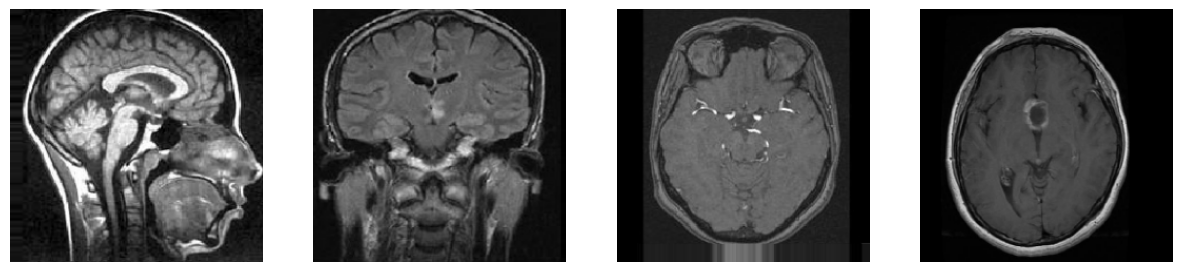

In [70]:
bt_train_dg = datagen.flow_from_directory(
                  directory=bt_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='training'
                  )

bt_val_dg = datagen.flow_from_directory(
                  directory=bt_path_train,
                  target_size=(image_size, image_size), # resize to this size
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=18,
                  shuffle=True,
                  subset='validation'
                  )

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
    # convert to unsigned integers for plotting
    image = next(bt_train_dg)[0].astype('uint8')

    # changing size for plotting the image
    image = np.squeeze(image)

    # plot raw pixel data
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

In [71]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)

# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

    
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    

h = model.fit(bt_train_dg, validation_data = bt_val_dg, steps_per_epoch=len(bt_train_dg) / 32, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
71/71 [==============================] - 215s 3s/step - loss: 1.3652 - accuracy: 0.3889 - val_loss: 1.3084 - val_accuracy: 0.3141 - lr: 0.0010
Epoch 2/30
71/71 [==============================] - 189s 3s/step - loss: 1.3256 - accuracy: 0.3611 - val_loss: 1.2363 - val_accuracy: 0.3194 - lr: 0.0010
Epoch 3/30
71/71 [==============================] - 146s 2s/step - loss: 1.3173 - accuracy: 0.3056 - val_loss: 1.1463 - val_accuracy: 0.4363 - lr: 0.0010
Epoch 4/30
71/71 [==============================] - 76s 1s/step - loss: 1.2340 - accuracy: 0.4444 - val_loss: 1.1493 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 5/30
71/71 [==============================] - 124s 2s/step - loss: 1.2525 - accuracy: 0.4722 - val_loss: 1.2015 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 6/30
71/71 [==============================] - 77s 1s/step - loss: 1.2068 - accuracy: 0.4306 - val_loss: 1.1124 - val_accuracy: 0.5131 - lr: 0.0010
Epoch 7/30
71/71 [==============================] - 121s 2s/step - loss: 1.275

For Brain Tumors, augmentation works even worse than for Alzheimer's. I will try Albumentations and add the augmented images to the training set to increase the number of images to train on. 

## Albumentations 

In [35]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.25)
])

In [40]:
def ald_augmentation(X_train, y_train):
    # Make a copy of the training set and augment it
    X_aug = X_train.copy()
    for image in X_aug:
        image = transform(image=image)['image']
        image = convert_to_tensor(image[:,:,:3])
        
    # Add augmented data to training set
    X_train = X_train + X_aug
    y_train = y_train + y_train
    # Prepare data for Tensorflow model
    X_train = np.array(X_train, dtype='float32')
    y_train = to_categorical(y_train, num_classes=4, dtype='float32')
    return X_train, y_train

In [39]:
def alb_prepare_data(path):
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
            # Change each image and append to X and y
            for image in listdir(f'{path}/{label}'):
                if '.jpg' in image:
                    image = cv2.imread(f'{path}/{label}/{image}')  
                    image = cv2.resize(image, (256, 256))

                    X.append(image)
                    y.append(num_label)

    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 

    # Change Validation set for TensorFlow models
    for image in X_val:
        image = convert_to_tensor(image[:,:,:3])

    X_val = np.array(X_val, dtype='float32')
    y_val = to_categorical(y_val, num_classes=4, dtype='float32')
    # Apply augmentation on trainig set 
    X_train, y_train = ald_augmentation(X_train, y_train)
    return X_train, X_val, y_train, y_val

### Alzheimer's

In [26]:
X_train, X_val, y_train, y_val = alb_prepare_data(al_path_train)

In [32]:
X_test, y_test = functions.read_grey_images_to_rgb(al_path_train, train_test = False)

In [163]:
# This model gave better scores on non augmented data
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [164]:
# Freeze layers
for layer in rn_model.layers:
    layer.trainable = False

In [165]:
model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=50, callbacks = [es, reduce_lr])

Epoch 1/50
240/240 [==============================] - 1302s 5s/step - loss: 2.9683 - accuracy: 0.7116 - val_loss: 1.2450 - val_accuracy: 0.8361
Epoch 2/50
240/240 [==============================] - 1283s 5s/step - loss: 0.5897 - accuracy: 0.9126 - val_loss: 0.7272 - val_accuracy: 0.8884
Epoch 3/50
240/240 [==============================] - 1857s 8s/step - loss: 0.1143 - accuracy: 0.9732 - val_loss: 0.9801 - val_accuracy: 0.8720
Epoch 4/50
240/240 [==============================] - 1888s 8s/step - loss: 0.1620 - accuracy: 0.9677 - val_loss: 4.2488 - val_accuracy: 0.6612
Epoch 5/50
240/240 [==============================] - 1895s 8s/step - loss: 0.9812 - accuracy: 0.9299 - val_loss: 2.5606 - val_accuracy: 0.8056
Epoch 6/50
240/240 [==============================] - 1873s 8s/step - loss: 0.1938 - accuracy: 0.9693 - val_loss: 1.0772 - val_accuracy: 0.8946
Epoch 7/50
240/240 [==============================] - 1827s 8s/step - loss: 0.6702 - accuracy: 0.9504 - val_loss: 1.2138 - val_accuracy:

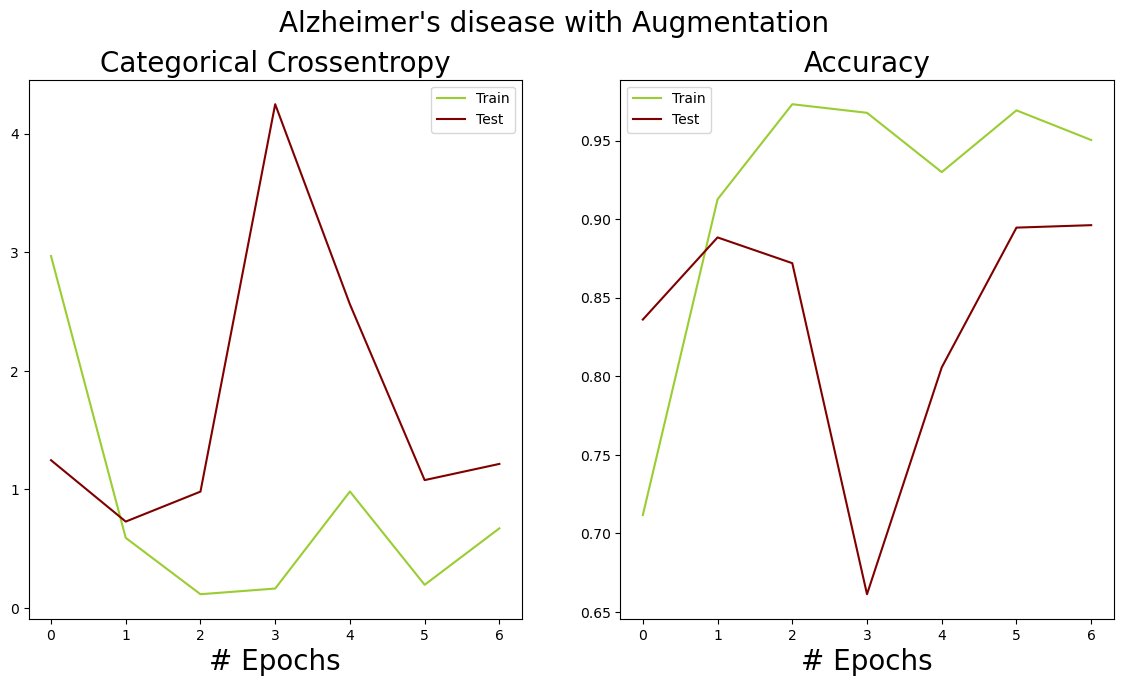

In [170]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with Augmentation')

Accuracy_score: 0.8884 



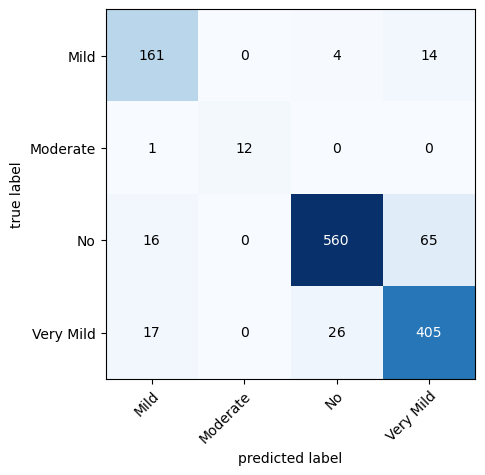

In [169]:
# Testing set Plot Confusion Matrix and print Accuracy
acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6427 



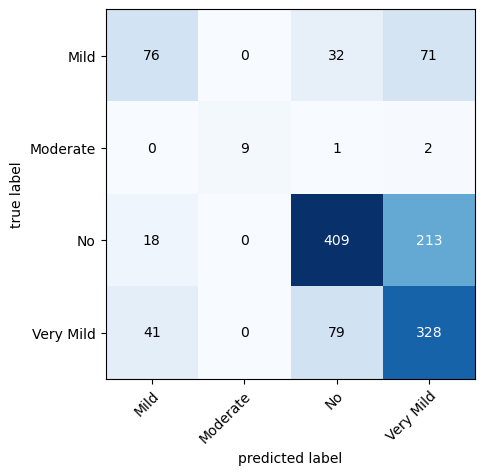

In [174]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Augmentation did not improve the accuracy of the model. Without Augmentation accuracy was 0.67

### Brain Tumor

In [41]:
X_train, X_val, y_train, y_val = alb_prepare_data(bt_path_train)
X_train.shape, y_train.shape

((4304, 256, 256, 3), (4304, 4))

In [42]:
X_test, y_test = functions.read_grey_images_to_rgb(bt_path_train, train_test = False)

In [45]:
model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), steps_per_epoch=len(X_train) / 32, epochs=50, callbacks = [es])

Epoch 1/50
134/134 [==============================] - 235s 2s/step - loss: 1.0643 - accuracy: 0.5948 - val_loss: 0.8713 - val_accuracy: 0.6852
Epoch 2/50
134/134 [==============================] - 230s 2s/step - loss: 0.6932 - accuracy: 0.7714 - val_loss: 0.6497 - val_accuracy: 0.8189
Epoch 3/50
134/134 [==============================] - 230s 2s/step - loss: 0.5270 - accuracy: 0.8569 - val_loss: 0.5625 - val_accuracy: 0.8663
Epoch 4/50
134/134 [==============================] - 229s 2s/step - loss: 0.4229 - accuracy: 0.9057 - val_loss: 0.5456 - val_accuracy: 0.8788
Epoch 5/50
134/134 [==============================] - 224s 2s/step - loss: 0.3462 - accuracy: 0.9410 - val_loss: 0.5375 - val_accuracy: 0.8914
Epoch 6/50
134/134 [==============================] - 230s 2s/step - loss: 0.3043 - accuracy: 0.9589 - val_loss: 0.5392 - val_accuracy: 0.9136
Epoch 7/50
134/134 [==============================] - 229s 2s/step - loss: 0.2899 - accuracy: 0.9649 - val_loss: 0.5410 - val_accuracy: 0.9067

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 255, 255, 64)      832       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 126, 126, 64)      16448     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 128)      

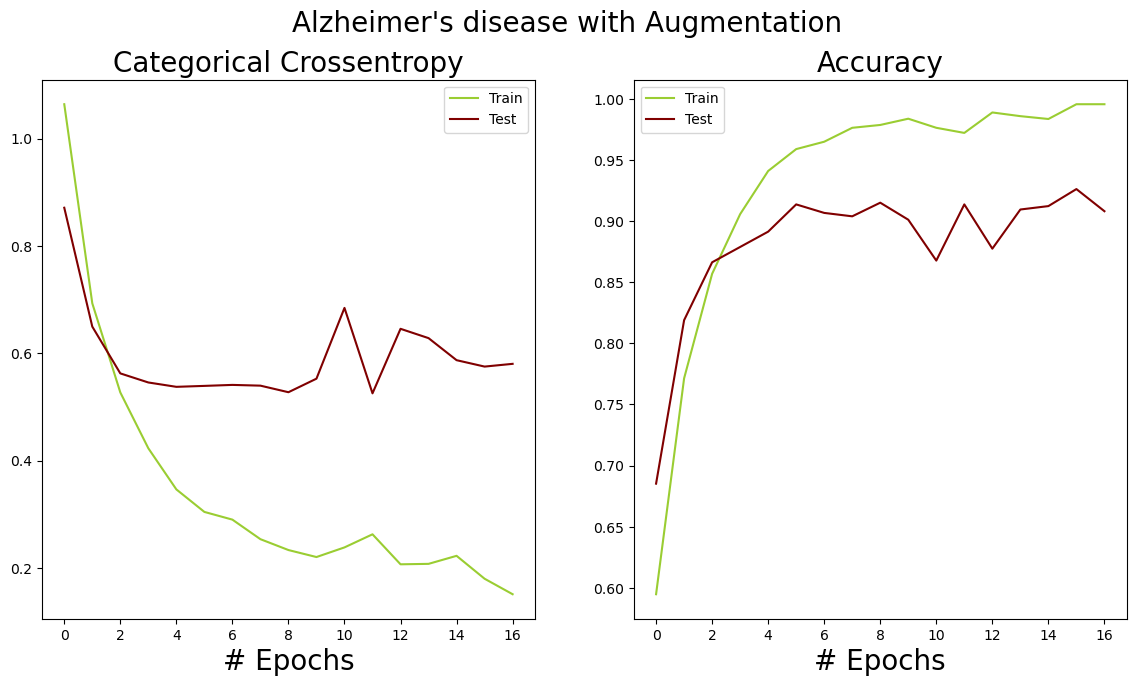

In [47]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with Augmentation')

Accuracy_score: 0.9136 



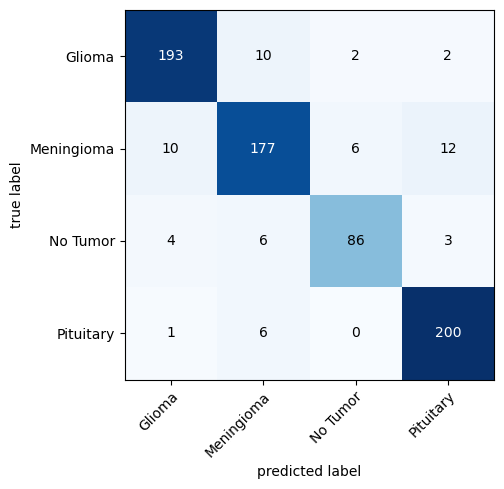

In [48]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

In [49]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/flatten_3/Reshape' defined at (most recent call last):
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ailin\AppData\Local\Temp\ipykernel_25744\2835778489.py", line 2, in <module>
      functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
    File "C:\Users\ailin\Documents\GA\dsi\projects\MRI_scan_disease_recognition\code\functions.py", line 58, in acc_conf_matrix
      predictions = np.concatenate([predictions, model.predict(X, verbose = False).argmax(axis=1)])
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ailin\anaconda3\envs\capstone\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_4/flatten_3/Reshape'
Input to reshape is a tensor with 589824 values, but the requested shape requires a multiple of 25088
	 [[{{node sequential_4/flatten_3/Reshape}}]] [Op:__inference_predict_function_203628]

---

I have tried ImageDataGenerator and Albumentations neither of them imroved the scores of the models.